In [18]:
# Generic JSON to Excel Converter
import pandas as pd
import json
import os
from datetime import datetime
import numpy as np

def json_to_excel_generic(json_file_path=None, output_filename=None, auto_detect=True):
    """
    Generic function to convert any JSON file to comprehensive Excel format
    
    Parameters:
    - json_file_path: Path to JSON file (if None, will find latest)
    - output_filename: Output Excel filename (if None, auto-generated)
    - auto_detect: Whether to auto-detect and handle special structures
    
    Returns:
    - output_filename: Path to created Excel file
    """
    
    print("🚀 GENERIC JSON TO EXCEL CONVERTER")
    print("=" * 50)
    
    # Step 1: Find and load JSON file
    if json_file_path is None:
        # Auto-detect latest JSON file
        json_files = [f for f in os.listdir('.') if f.endswith('.json') and not f.startswith('tmp')]
        if not json_files:
            print("❌ No JSON files found")
            return None
        
        json_file_path = max(json_files, key=os.path.getmtime)
        print(f"📁 Auto-detected latest JSON: {json_file_path}")
    else:
        print(f"📁 Using specified JSON: {json_file_path}")
    
    # Load JSON data
    try:
        with open(json_file_path, 'r') as f:
            json_data = json.load(f)
        print(f"✅ Loaded JSON successfully")
    except Exception as e:
        print(f"❌ Error loading JSON: {e}")
        return None
    
    # Step 2: Generate output filename
    if output_filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        base_name = os.path.splitext(os.path.basename(json_file_path))[0]
        output_filename = f"{base_name}_EXCEL_{timestamp}.xlsx"
    
    print(f"📄 Output Excel: {output_filename}")
    
    # Step 3: Analyze JSON structure
    print(f"\\n🔍 JSON STRUCTURE ANALYSIS:")
    print(f"   📋 Top-level keys: {list(json_data.keys())}")
    
    # Step 4: Create Excel with multiple sheets
    with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
        sheet_count = 0
        
        # Sheet 1: Raw JSON structure overview
        json_overview = []
        
        def analyze_json_structure(data, prefix=""):
            """Recursively analyze JSON structure"""
            if isinstance(data, dict):
                for key, value in data.items():
                    full_key = f"{prefix}.{key}" if prefix else key
                    if isinstance(value, (dict, list)):
                        json_overview.append({
                            'Key': full_key,
                            'Type': type(value).__name__,
                            'Length': len(value) if hasattr(value, '__len__') else 'N/A',
                            'Sample_Value': str(value)[:100] + "..." if len(str(value)) > 100 else str(value)
                        })
                        if isinstance(value, dict) and len(value) < 20:  # Don't go too deep
                            analyze_json_structure(value, full_key)
                    else:
                        json_overview.append({
                            'Key': full_key,
                            'Type': type(value).__name__,
                            'Length': len(str(value)) if value is not None else 0,
                            'Sample_Value': str(value)
                        })
            elif isinstance(data, list) and len(data) > 0:
                # Analyze first item in list
                json_overview.append({
                    'Key': f"{prefix}[0]",
                    'Type': type(data[0]).__name__,
                    'Length': len(data),
                    'Sample_Value': str(data[0])[:100] + "..." if len(str(data[0])) > 100 else str(data[0])
                })
        
        analyze_json_structure(json_data)
        
        if json_overview:
            overview_df = pd.DataFrame(json_overview)
            overview_df.to_excel(writer, sheet_name='JSON_Structure', index=False)
            sheet_count += 1
            print(f"✅ JSON_Structure sheet: {len(overview_df)} entries")
        
        # Sheet 2: Main data detection and extraction
        main_data_found = False
        
        # Look for common patterns that indicate main data
        data_candidates = []
        for key, value in json_data.items():
            if isinstance(value, list) and len(value) > 0:
                if isinstance(value[0], dict):
                    data_candidates.append((key, value, len(value)))
        
        # Sort by list length (assuming longer lists are more likely to be main data)
        data_candidates.sort(key=lambda x: x[2], reverse=True)
        
        if data_candidates:
            # Use the largest list as main data
            main_key, main_data, main_count = data_candidates[0]
            print(f"   🎯 Main data detected: '{main_key}' with {main_count} items")
            
            try:
                main_df = pd.DataFrame(main_data)
                main_df.to_excel(writer, sheet_name=main_key.title(), index=False)
                sheet_count += 1
                print(f"✅ {main_key.title()} sheet: {len(main_df)} rows, {len(main_df.columns)} columns")
                main_data_found = True
                
                # If this looks like stent data, create additional analysis
                if auto_detect and any(col in main_df.columns for col in ['ring', 'crown_type', 'chord_centerline', 'x_left_mm']):
                    print("   🔬 Stent data detected, creating specialized analysis...")
                    
                    # Ring summary
                    if 'ring' in main_df.columns:
                        ring_summary = main_df.groupby('ring').agg({
                            main_df.columns[0]: 'count',  # Use first column for count
                            **{col: ['mean', 'min', 'max'] for col in main_df.select_dtypes(include=[np.number]).columns[:5]}
                        }).round(6)
                        ring_summary.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in ring_summary.columns]
                        ring_summary.to_excel(writer, sheet_name='Ring_Summary')
                        sheet_count += 1
                        print(f"✅ Ring_Summary sheet: {len(ring_summary)} rings")
                    
                    # Crown chord analysis if available
                    if 'chord_centerline' in main_df.columns or 'chord_outer' in main_df.columns:
                        chord_analysis = []
                        for _, row in main_df.iterrows():
                            for chord_type in ['chord_centerline', 'chord_outer']:
                                if chord_type in row and row[chord_type] is not None:
                                    try:
                                        if isinstance(row[chord_type], list) and len(row[chord_type]) >= 2:
                                            coords = row[chord_type]
                                            start, end = coords[0], coords[1]
                                            length = ((end[0] - start[0])**2 + (end[1] - start[1])**2)**0.5
                                            
                                            chord_analysis.append({
                                                'Ring': row.get('ring', 'N/A'),
                                                'Column': row.get('col', 'N/A'),
                                                'Crown_Type': row.get('crown_type', 'N/A'),
                                                'Chord_Type': chord_type,
                                                'Start_X': start[0],
                                                'Start_Y': start[1],
                                                'End_X': end[0],
                                                'End_Y': end[1],
                                                'Length': length
                                            })
                                    except:
                                        pass
                        
                        if chord_analysis:
                            chord_df = pd.DataFrame(chord_analysis)
                            chord_df.to_excel(writer, sheet_name='Chord_Analysis', index=False)
                            sheet_count += 1
                            print(f"✅ Chord_Analysis sheet: {len(chord_df)} chord entries")
                
            except Exception as e:
                print(f"⚠️ Could not create main data sheet: {e}")
        
        # Sheet 3: Extract other top-level objects
        for key, value in json_data.items():
            if key == main_key and main_data_found:
                continue  # Skip main data, already processed
            
            try:
                if isinstance(value, dict):
                    # Convert dict to DataFrame
                    if all(isinstance(v, (int, float, str, bool, type(None))) for v in value.values()):
                        # Simple key-value pairs
                        df = pd.DataFrame(list(value.items()), columns=['Key', 'Value'])
                        df.to_excel(writer, sheet_name=key.title()[:31], index=False)  # Excel sheet name limit
                        sheet_count += 1
                        print(f"✅ {key.title()} sheet: {len(df)} parameters")
                    else:
                        # Complex nested structure
                        flattened = []
                        def flatten_dict(d, parent_key=''):
                            for k, v in d.items():
                                new_key = f"{parent_key}.{k}" if parent_key else k
                                if isinstance(v, dict):
                                    flatten_dict(v, new_key)
                                else:
                                    flattened.append({'Key': new_key, 'Value': str(v)})
                        
                        flatten_dict(value)
                        if flattened:
                            df = pd.DataFrame(flattened)
                            df.to_excel(writer, sheet_name=key.title()[:31], index=False)
                            sheet_count += 1
                            print(f"✅ {key.title()} sheet: {len(df)} nested parameters")
                
                elif isinstance(value, list) and len(value) > 0:
                    if isinstance(value[0], dict):
                        # List of objects
                        df = pd.DataFrame(value)
                        df.to_excel(writer, sheet_name=key.title()[:31], index=False)
                        sheet_count += 1
                        print(f"✅ {key.title()} sheet: {len(df)} rows")
                    else:
                        # Simple list
                        df = pd.DataFrame({key: value})
                        df.to_excel(writer, sheet_name=key.title()[:31], index=False)
                        sheet_count += 1
                        print(f"✅ {key.title()} sheet: {len(df)} items")
                        
            except Exception as e:
                print(f"⚠️ Could not process '{key}': {e}")
        
        # Sheet 4: Metadata
        metadata = {
            'Export_Date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'Source_JSON': json_file_path,
            'JSON_Size_Bytes': os.path.getsize(json_file_path),
            'Top_Level_Keys': len(json_data.keys()),
            'Top_Level_Key_Names': ', '.join(json_data.keys()),
            'Main_Data_Key': main_key if main_data_found else 'Not detected',
            'Main_Data_Count': main_count if main_data_found else 0,
            'Total_Excel_Sheets': sheet_count + 1,  # +1 for metadata itself
            'Auto_Detection_Used': auto_detect,
            'Excel_Filename': output_filename
        }
        
        # Add JSON-specific metadata
        if 'meta' in json_data:
            meta_data = json_data['meta']
            for key, value in meta_data.items():
                metadata[f'JSON_Meta_{key}'] = str(value)
        
        metadata_df = pd.DataFrame(list(metadata.items()), columns=['Property', 'Value'])
        metadata_df.to_excel(writer, sheet_name='Metadata', index=False)
        sheet_count += 1
        print(f"✅ Metadata sheet: {len(metadata_df)} properties")
    
    print(f"\\n🎉 Excel file created successfully!")
    print(f"📊 Total sheets: {sheet_count}")
    print(f"📁 Location: {os.path.abspath(output_filename)}")
    
    return output_filename

# Test the generic function
print("🧪 Testing Generic JSON to Excel Converter")

🧪 Testing Generic JSON to Excel Converter


In [19]:
# Execute the generic JSON to Excel converter
print("🚀 Executing Generic JSON to Excel Converter")
print("=" * 60)

# Run with auto-detection of latest JSON file
excel_output = json_to_excel_generic(auto_detect=True)

if excel_output:
    print(f"\\n✅ SUCCESS! Excel file created: {excel_output}")
    print(f"📁 Full path: {os.path.abspath(excel_output)}")
    
    # Show file size
    file_size = os.path.getsize(excel_output)
    print(f"📊 File size: {file_size:,} bytes ({file_size/1024:.1f} KB)")
    
    # Quick verification
    try:
        with pd.ExcelWriter(excel_output, engine='openpyxl', mode='a') as writer:
            sheet_names = writer.book.sheetnames
        print(f"📋 Sheets created: {sheet_names}")
    except Exception as e:
        print(f"⚠️ Could not verify sheets: {e}")
        
else:
    print("❌ Failed to create Excel file")

print("\\n" + "=" * 60)

🚀 Executing Generic JSON to Excel Converter
🚀 GENERIC JSON TO EXCEL CONVERTER
📁 Auto-detected latest JSON: stentframe_cell_chords_wavephase_bulgeedges_20250907_043210.json
✅ Loaded JSON successfully
📄 Output Excel: stentframe_cell_chords_wavephase_bulgeedges_20250907_043210_EXCEL_20250907_002810.xlsx
\n🔍 JSON STRUCTURE ANALYSIS:
   📋 Top-level keys: ['meta', 'parameters', 'rings', 'gaps_policy', 'cells']
✅ JSON_Structure sheet: 23 entries
   🎯 Main data detected: 'cells' with 48 items
✅ Cells sheet: 48 rows, 23 columns
   🔬 Stent data detected, creating specialized analysis...
✅ Ring_Summary sheet: 6 rings
✅ Chord_Analysis sheet: 96 chord entries
✅ Meta sheet: 4 parameters
✅ Parameters sheet: 6 parameters
✅ Rings sheet: 3 nested parameters
✅ Gaps_Policy sheet: 5 parameters
✅ Metadata sheet: 14 properties
\n🎉 Excel file created successfully!
📊 Total sheets: 9
📁 Location: d:\SynologyDrive\Projects\VisualStudio\Fusion\stent\stent_frame\stentframe_cell_chords_wavephase_bulgeedges_20250907_

In [20]:
# Load and Visualize New JSON Structure with Full Wave Cells and Chord Lines
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import json
import numpy as np

def load_new_json_structure():
    """Load the new JSON file with full wave structure"""
    json_file = "stentframe_fullwave_bulgeedges_phase_20250907_053739.json"
    
    print(f"🔍 Loading new JSON structure: {json_file}")
    
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    print(f"✅ Loaded JSON with {len(data['cells'])} cells")
    print(f"📋 Structure: {list(data.keys())}")
    
    # Convert to DataFrame for easier analysis
    cells_df = pd.DataFrame(data['cells'])
    
    print(f"📊 Cells DataFrame shape: {cells_df.shape}")
    print(f"🏁 Rings: {sorted(cells_df['ring'].unique())}")
    print(f"📍 Columns per ring: {cells_df.groupby('ring')['col'].nunique().tolist()}")
    
    return data, cells_df

def draw_full_wave_cells_and_chords(data, cells_df, num_cells=4, show_details=True):
    """
    Draw full wave cells with chord lines based on new JSON structure
    
    Parameters:
    - data: Full JSON data
    - cells_df: DataFrame of cells
    - num_cells: Number of adjacent cells to show
    - show_details: Whether to show detailed annotations
    """
    
    print(f"🎨 Drawing {num_cells} adjacent full wave cells with chord lines")
    
    # Select first few cells for visualization
    selected_cells = cells_df.head(num_cells)
    
    # Create figure with multiple subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Full Wave Stent Cells with Chord Lines - New JSON Structure', fontsize=16, fontweight='bold')
    
    # Color schemes
    cell_colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink', 'lightgray']
    chord_colors = {'left': 'red', 'right': 'blue'}
    
    # Plot 1: Individual cells layout
    ax1.set_title('Individual Cell Layout', fontsize=14, fontweight='bold')
    
    for i, (_, cell) in enumerate(selected_cells.iterrows()):
        if i >= len(cell_colors):
            break
            
        # Draw cell boundary
        x_left = cell['x_left_mm']
        x_right = cell['x_right_mm'] 
        y_top = cell['y_top_edge_mm']
        y_bottom = cell['y_bottom_edge_mm']
        
        width = x_right - x_left
        height = y_bottom - y_top
        
        # Cell rectangle
        rect = patches.Rectangle((x_left, y_top), width, height, 
                               linewidth=2, edgecolor='black', 
                               facecolor=cell_colors[i], alpha=0.3)
        ax1.add_patch(rect)
        
        # Left chord (centerline and outer)
        if 'left_chord_centerline' in cell and cell['left_chord_centerline']:
            left_center = np.array(cell['left_chord_centerline'])
            ax1.plot(left_center[:, 0], left_center[:, 1], 'r-', linewidth=3, 
                    label=f'Left Centerline {i+1}' if i == 0 else "")
            ax1.plot(left_center[:, 0], left_center[:, 1], 'ro', markersize=6)
            
        if 'left_chord_outer' in cell and cell['left_chord_outer']:
            left_outer = np.array(cell['left_chord_outer'])
            ax1.plot(left_outer[:, 0], left_outer[:, 1], 'r--', linewidth=2, 
                    label=f'Left Outer {i+1}' if i == 0 else "")
            
        # Right chord (centerline and outer)
        if 'right_chord_centerline' in cell and cell['right_chord_centerline']:
            right_center = np.array(cell['right_chord_centerline'])
            ax1.plot(right_center[:, 0], right_center[:, 1], 'b-', linewidth=3,
                    label=f'Right Centerline {i+1}' if i == 0 else "")
            ax1.plot(right_center[:, 0], right_center[:, 1], 'bo', markersize=6)
            
        if 'right_chord_outer' in cell and cell['right_chord_outer']:
            right_outer = np.array(cell['right_chord_outer'])
            ax1.plot(right_outer[:, 0], right_outer[:, 1], 'b--', linewidth=2,
                    label=f'Right Outer {i+1}' if i == 0 else "")
        
        # Cell annotations
        if show_details:
            center_x = (x_left + x_right) / 2
            center_y = (y_top + y_bottom) / 2
            ax1.text(center_x, center_y, f'R{cell["ring"]}C{cell["col"]}\\n{cell["left_crown_pos"]}/{cell["right_crown_pos"]}', 
                    ha='center', va='center', fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    ax1.set_xlabel('X Position (mm)')
    ax1.set_ylabel('Y Position (mm)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_aspect('equal')
    
    # Plot 2: Chord analysis
    ax2.set_title('Chord Line Analysis', fontsize=14, fontweight='bold')
    
    chord_data = []
    for i, (_, cell) in enumerate(selected_cells.iterrows()):
        # Analyze left chords
        if 'left_chord_centerline' in cell and cell['left_chord_centerline']:
            left_center = cell['left_chord_centerline']
            length = np.sqrt((left_center[1][0] - left_center[0][0])**2 + 
                           (left_center[1][1] - left_center[0][1])**2)
            chord_data.append({
                'Cell': f'R{cell["ring"]}C{cell["col"]}',
                'Chord': 'Left Centerline',
                'Length': length,
                'Start_X': left_center[0][0],
                'Start_Y': left_center[0][1],
                'End_X': left_center[1][0],
                'End_Y': left_center[1][1],
                'Crown_Pos': cell['left_crown_pos']
            })
            
        # Analyze right chords  
        if 'right_chord_centerline' in cell and cell['right_chord_centerline']:
            right_center = cell['right_chord_centerline']
            length = np.sqrt((right_center[1][0] - right_center[0][0])**2 + 
                           (right_center[1][1] - right_center[0][1])**2)
            chord_data.append({
                'Cell': f'R{cell["ring"]}C{cell["col"]}',
                'Chord': 'Right Centerline', 
                'Length': length,
                'Start_X': right_center[0][0],
                'Start_Y': right_center[0][1],
                'End_X': right_center[1][0],
                'End_Y': right_center[1][1],
                'Crown_Pos': cell['right_crown_pos']
            })
    
    chord_df = pd.DataFrame(chord_data)
    
    # Plot chord lengths
    if not chord_df.empty:
        chord_df.plot(x='Cell', y='Length', kind='bar', ax=ax2, 
                     color=['red' if 'Left' in x else 'blue' for x in chord_df['Chord']])
        ax2.set_ylabel('Chord Length (mm)')
        ax2.tick_params(axis='x', rotation=45)
        
        # Add values on bars
        for i, v in enumerate(chord_df['Length']):
            ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Plot 3: Crown positioning
    ax3.set_title('Crown Position Analysis', fontsize=14, fontweight='bold')
    
    crown_positions = []
    for _, cell in selected_cells.iterrows():
        crown_positions.extend([
            {'Cell': f'R{cell["ring"]}C{cell["col"]}', 'Side': 'Left', 'Position': cell['left_crown_pos']},
            {'Cell': f'R{cell["ring"]}C{cell["col"]}', 'Side': 'Right', 'Position': cell['right_crown_pos']}
        ])
    
    crown_df = pd.DataFrame(crown_positions)
    if not crown_df.empty:
        crown_counts = crown_df.groupby(['Cell', 'Position']).size().unstack(fill_value=0)
        crown_counts.plot(kind='bar', stacked=True, ax=ax3, colormap='Set3')
        ax3.set_ylabel('Count')
        ax3.tick_params(axis='x', rotation=45)
        ax3.legend(title='Crown Position')
    
    # Plot 4: Geometric parameters
    ax4.set_title('Cell Geometric Parameters', fontsize=14, fontweight='bold')
    
    # Create parameter comparison
    params = []
    for _, cell in selected_cells.iterrows():
        params.append({
            'Cell': f'R{cell["ring"]}C{cell["col"]}',
            'Wave_Height': cell.get('wave_height_mm', 0),
            'Wave_Width': cell.get('wave_width_mm', 0),
            'Strut_Width': cell.get('strut_width_mm', 0),
            'Theta_Deg': cell.get('theta_deg', 0)
        })
    
    params_df = pd.DataFrame(params)
    if not params_df.empty:
        # Plot multiple parameters
        x_pos = np.arange(len(params_df))
        width = 0.2
        
        ax4.bar(x_pos - width*1.5, params_df['Wave_Height'], width, label='Wave Height (mm)', alpha=0.8)
        ax4.bar(x_pos - width*0.5, params_df['Wave_Width'], width, label='Wave Width (mm)', alpha=0.8)
        ax4.bar(x_pos + width*0.5, params_df['Strut_Width']*10, width, label='Strut Width (mm×10)', alpha=0.8)
        
        # Secondary y-axis for theta
        ax4_twin = ax4.twinx()
        ax4_twin.bar(x_pos + width*1.5, params_df['Theta_Deg'], width, 
                    label='Theta (deg)', alpha=0.8, color='orange')
        
        ax4.set_xlabel('Cell')
        ax4.set_ylabel('Dimensions (mm)')
        ax4_twin.set_ylabel('Angle (degrees)')
        ax4.set_xticks(x_pos)
        ax4.set_xticklabels(params_df['Cell'], rotation=45)
        ax4.legend(loc='upper left')
        ax4_twin.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return chord_df, crown_df, params_df

# Execute the visualization
print("🚀 Loading and visualizing new JSON structure...")
new_data, new_cells_df = load_new_json_structure()

print("\\n📊 Sample cell data:")
print(new_cells_df.head(2).to_string())

print("\\n🎨 Creating comprehensive visualization...")

🚀 Loading and visualizing new JSON structure...
🔍 Loading new JSON structure: stentframe_fullwave_bulgeedges_phase_20250907_053739.json
✅ Loaded JSON with 48 cells
📋 Structure: ['meta', 'parameters', 'rings', 'gaps_policy', 'cells']
📊 Cells DataFrame shape: (48, 25)
🏁 Rings: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
📍 Columns per ring: [8, 8, 8, 8, 8, 8]
\n📊 Sample cell data:
   ring  col  x_left_mm  x_right_mm  y_top_edge_mm  y_bottom_edge_mm     edge_kind_top  edge_kind_bottom  edge_margin_top_mm  edge_margin_bottom_mm left_crown_pos                       left_chord_centerline                       left_chord_outer right_crown_pos                        right_chord_centerline                             right_chord_outer  wave_height_mm  wave_width_mm  strut_width_mm   theta_deg  Rc_mm  chord_center_len_mm  chord_outer_len_mm  side_keepout_mm  h_outer_mm
0     1    0   0.000000    0.706858      -0.170507          1.534317  metal_outer_edge  metal_

🎨 Creating visualization of full wave cells and chord lines...
🎨 Drawing 4 adjacent full wave cells with chord lines


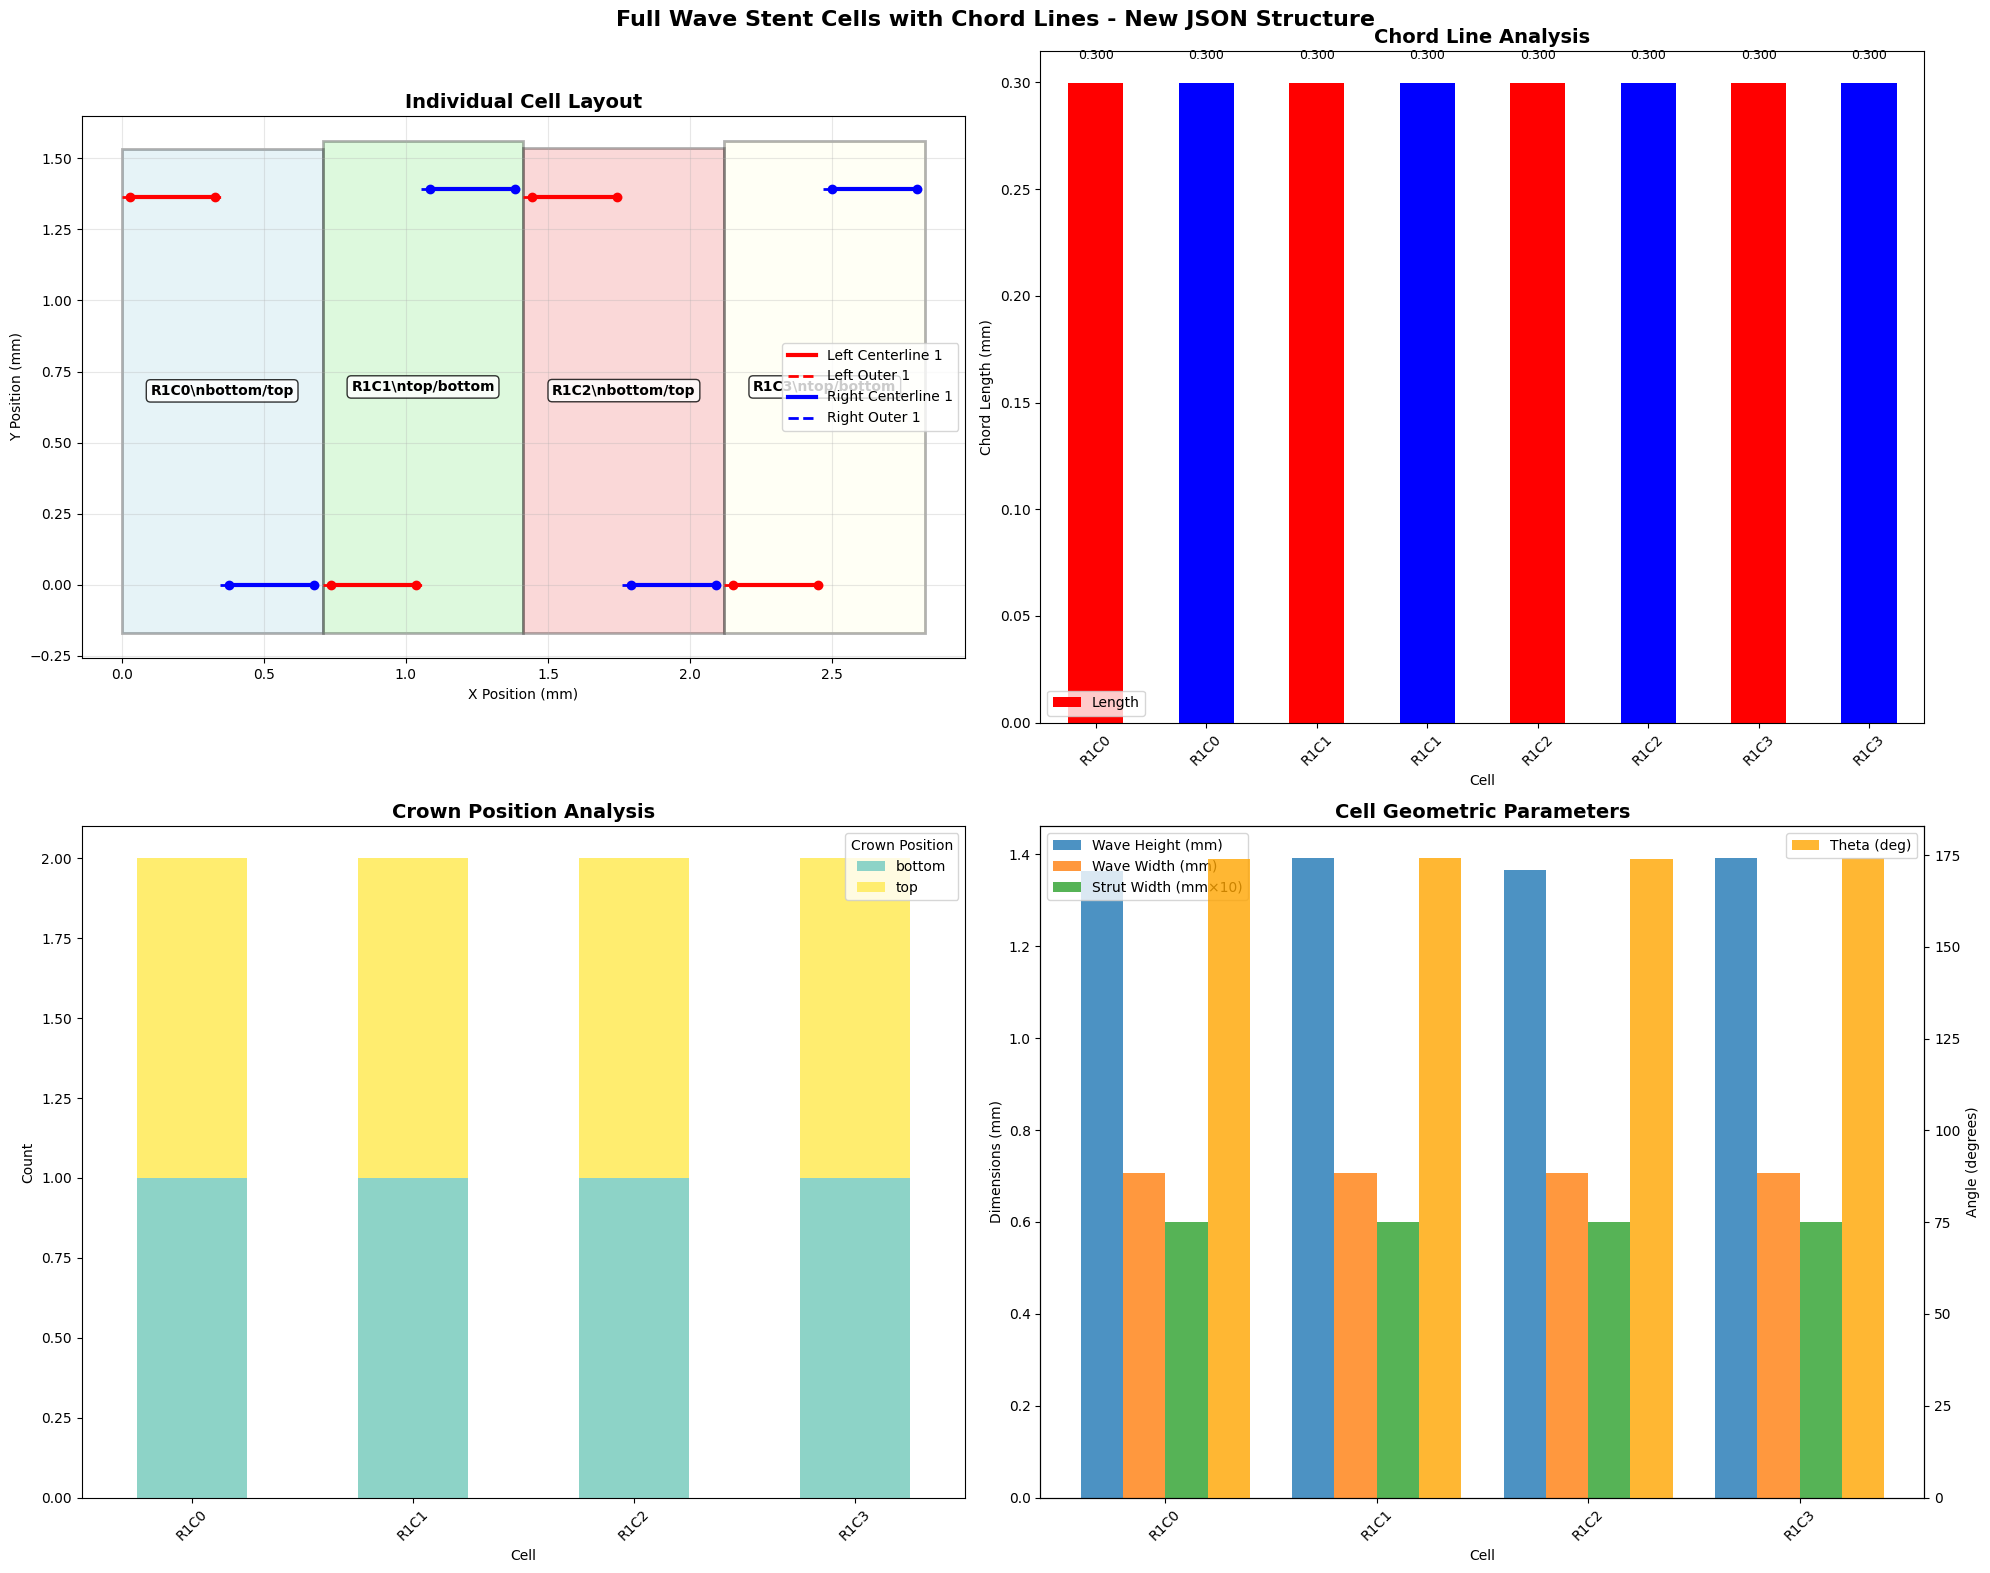

\n📊 CHORD ANALYSIS RESULTS:
Cell            Chord   Length  Start_X  Start_Y    End_X    End_Y Crown_Pos
R1C0  Left Centerline 0.299583 0.029958 1.363810 0.329541 1.363810    bottom
R1C0 Right Centerline 0.299582 0.377318 0.000000 0.676900 0.000000       top
R1C1  Left Centerline 0.299604 0.736819 0.000000 1.036423 0.000000       top
R1C1 Right Centerline 0.299604 1.084152 1.391429 1.383756 1.391429    bottom
R1C2  Left Centerline 0.299584 1.443675 1.365714 1.743259 1.365714    bottom
R1C2 Right Centerline 0.299584 1.791033 0.000000 2.090617 0.000000       top
R1C3  Left Centerline 0.299605 2.150535 0.000000 2.450140 0.000000       top
R1C3 Right Centerline 0.299604 2.497869 1.391429 2.797473 1.391429    bottom
\n📏 Average chord length: 0.2996 mm
📐 Chord length range: 0.2996 - 0.2996 mm
\n🏁 CROWN POSITION ANALYSIS:
Side      Left  Right
Position             
bottom       2      2
top          2      2
\n📐 GEOMETRIC PARAMETERS:
Cell  Wave_Height  Wave_Width  Strut_Width  Theta_Deg
R1C0 

In [21]:
# Execute the full wave cell and chord visualization
print("🎨 Creating visualization of full wave cells and chord lines...")

# Draw 4 adjacent cells with detailed analysis
chord_analysis, crown_analysis, geometric_analysis = draw_full_wave_cells_and_chords(
    new_data, new_cells_df, num_cells=4, show_details=True
)

print("\\n📊 CHORD ANALYSIS RESULTS:")
if not chord_analysis.empty:
    print(chord_analysis.to_string(index=False))
    print(f"\\n📏 Average chord length: {chord_analysis['Length'].mean():.4f} mm")
    print(f"📐 Chord length range: {chord_analysis['Length'].min():.4f} - {chord_analysis['Length'].max():.4f} mm")

print("\\n🏁 CROWN POSITION ANALYSIS:")
if not crown_analysis.empty:
    crown_summary = crown_analysis.groupby(['Position', 'Side']).size().unstack(fill_value=0)
    print(crown_summary)

print("\\n📐 GEOMETRIC PARAMETERS:")
if not geometric_analysis.empty:
    print(geometric_analysis.to_string(index=False))
    
print("\\n✅ Visualization complete!")
print("🔍 The plots show:")
print("   1️⃣ Individual cell layout with chord lines (red=left, blue=right)")
print("   2️⃣ Chord length analysis for manufacturing")
print("   3️⃣ Crown position distribution")
print("   4️⃣ Key geometric parameters comparison")

🚀 UPDATED STENT VISUALIZATION
📁 Loading latest JSON: stentframe_fullwave_centerline_INTERNALedges_dynKeepout_20250907_164638.json
✅ Loaded JSON with structure: ['meta', 'parameters', 'gaps_policy', 'rings', 'cells']
📋 Note: Per-cell dynamic x_keepout derived from straight-leg tangency to crown (alpha = delta). Internal edges at M = s_center + w/2 keep chords inside; all Y ∈ [0, 8].
\n📊 Updated JSON Analysis:
   🔧 Format: Per-cell dynamic x_keepout derived from straight-leg tangency to crown (alpha = delta). Internal edges at M = s_center + w/2 keep chords inside; all Y ∈ [0, 8].
   📊 Cells: 48
   💎 New Features: Dynamic keepout zones, tangency validation
🎨 Creating updated stent visualization with dynamic keepout zones...
📊 Visualizing 48 cells across 6 rings
🔧 New features: Dynamic x_keepout, internal edges, tangency validation


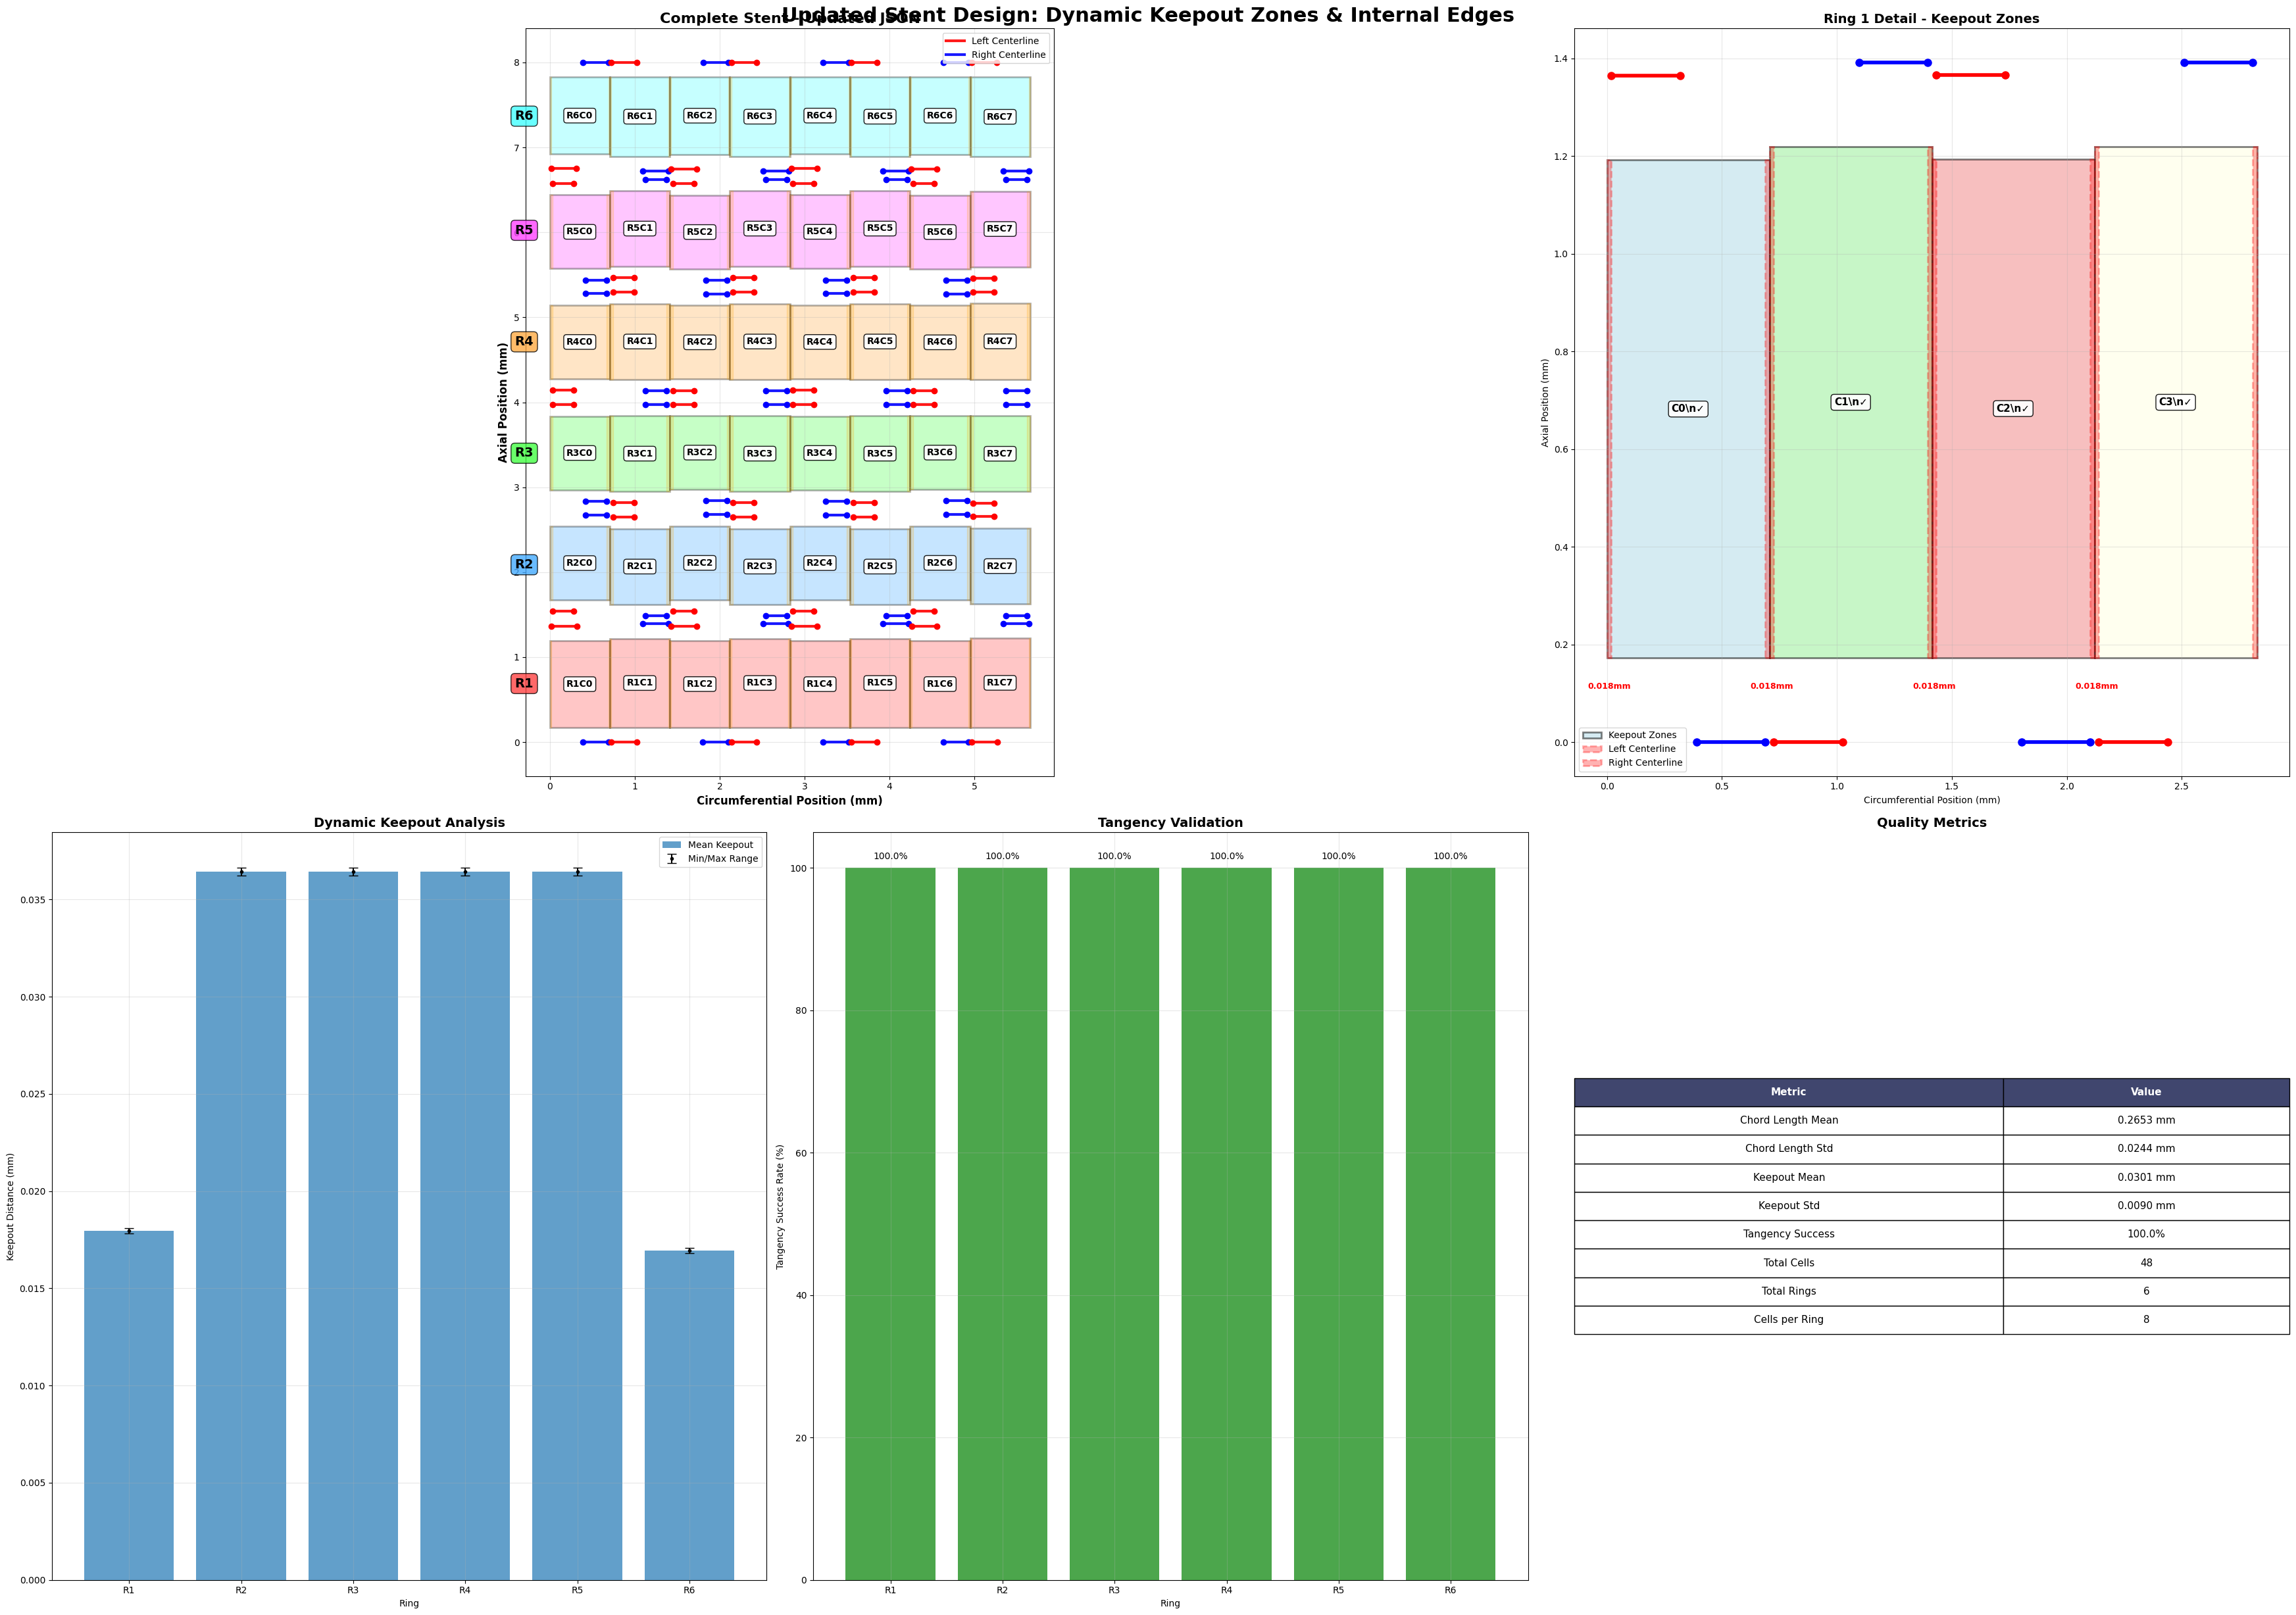

\n✅ Updated stent visualization complete!
🎯 Key new features visualized:
   🟠 Orange zones: Dynamic keepout areas
   ✓ Green checkmarks: Tangency validation success
   📊 Comprehensive quality metrics
   🔧 Internal edge positioning


In [2]:
# Updated Stent Visualization with Latest JSON Structure
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import json
import numpy as np

def load_updated_json():
    """Load the most recent JSON file with updated structure"""
    json_files = [f for f in os.listdir('.') if f.endswith('.json') and not f.startswith('tmp')]
    if not json_files:
        print("❌ No JSON files found")
        return None, None
    
    latest_json = max(json_files, key=os.path.getmtime)
    print(f"📁 Loading latest JSON: {latest_json}")
    
    with open(latest_json, 'r') as f:
        data = json.load(f)
    
    print(f"✅ Loaded JSON with structure: {list(data.keys())}")
    print(f"📋 Note: {data['meta'].get('note', 'No note')}")
    
    return data, latest_json

def draw_updated_stent_comprehensive(data, figure_size=(35, 25)):
    """
    Create comprehensive visualization of updated stent with dynamic keepout zones
    """
    print("🎨 Creating updated stent visualization with dynamic keepout zones...")
    
    # Extract data
    cells_df = pd.DataFrame(data['cells'])
    params = data.get('parameters', {})
    meta = data.get('meta', {})
    
    print(f"📊 Visualizing {len(cells_df)} cells across {len(cells_df['ring'].unique())} rings")
    print(f"🔧 New features: Dynamic x_keepout, internal edges, tangency validation")
    
    # Create comprehensive figure with multiple subplots
    fig = plt.figure(figsize=figure_size)
    fig.suptitle('Updated Stent Design: Dynamic Keepout Zones & Internal Edges', 
                fontsize=22, fontweight='bold')
    
    # Create 2x3 subplot grid
    ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)  # Full stent layout
    ax2 = plt.subplot2grid((2, 3), (0, 2))  # Ring detail
    ax3 = plt.subplot2grid((2, 3), (1, 0))  # Keepout analysis
    ax4 = plt.subplot2grid((2, 3), (1, 1))  # Tangency analysis
    ax5 = plt.subplot2grid((2, 3), (1, 2))  # Quality metrics
    
    # Plot 1: Complete stent with updated features
    plot_complete_updated_stent(ax1, cells_df, "Complete Stent - Updated JSON")
    
    # Plot 2: Detailed ring view
    plot_ring_detail_updated(ax2, cells_df, "Ring 1 Detail - Keepout Zones")
    
    # Plot 3: Keepout zone analysis
    plot_keepout_analysis(ax3, cells_df, "Dynamic Keepout Analysis")
    
    # Plot 4: Tangency validation
    plot_tangency_analysis(ax4, cells_df, "Tangency Validation")
    
    # Plot 5: Quality metrics
    plot_quality_metrics(ax5, cells_df, "Quality Metrics")
    
    plt.tight_layout()
    plt.show()
    
    return fig

def plot_complete_updated_stent(ax, cells_df, title):
    """Plot complete stent with updated JSON features"""
    ax.set_title(title, fontsize=16, fontweight='bold')
    
    # Enhanced color scheme
    ring_colors = ['#FF4444', '#44AAFF', '#44FF44', '#FFAA44', '#FF44FF', '#44FFFF']
    color_map = {ring: ring_colors[i % len(ring_colors)] 
                for i, ring in enumerate(sorted(cells_df['ring'].unique()))}
    
    for idx, (_, cell) in enumerate(cells_df.iterrows()):
        # Cell boundaries
        x_left = cell['x_left_mm']
        x_right = cell['x_right_mm']
        y_top = cell['y_top_edge_mm']
        y_bottom = cell['y_bottom_edge_mm']
        
        width = x_right - x_left
        height = y_bottom - y_top
        
        # Draw cell with internal edges
        rect = patches.Rectangle((x_left, y_top), width, height,
                               linewidth=2, edgecolor='black',
                               facecolor=color_map[cell['ring']], alpha=0.3)
        ax.add_patch(rect)
        
        # Draw keepout zones (if available)
        if 'x_keepout_mm' in cell:
            keepout = cell['x_keepout_mm']
            # Left keepout zone
            keepout_rect_left = patches.Rectangle((x_left, y_top), keepout, height,
                                                linewidth=1, edgecolor='orange',
                                                facecolor='orange', alpha=0.2)
            ax.add_patch(keepout_rect_left)
            
            # Right keepout zone
            keepout_rect_right = patches.Rectangle((x_right - keepout, y_top), keepout, height,
                                                 linewidth=1, edgecolor='orange',
                                                 facecolor='orange', alpha=0.2)
            ax.add_patch(keepout_rect_right)
        
        # Draw centerline chords
        if all(col in cell for col in ['left_cl_x1', 'left_cl_y', 'left_cl_x2']):
            left_x1, left_y, left_x2 = cell['left_cl_x1'], cell['left_cl_y'], cell['left_cl_x2']
            ax.plot([left_x1, left_x2], [left_y, left_y], 'r-', linewidth=3, alpha=0.9,
                   label='Left Centerline' if idx == 0 else "")
            ax.plot([left_x1, left_x2], [left_y, left_y], 'ro', markersize=6)
        
        if all(col in cell for col in ['right_cl_x1', 'right_cl_y', 'right_cl_x2']):
            right_x1, right_y, right_x2 = cell['right_cl_x1'], cell['right_cl_y'], cell['right_cl_x2']
            ax.plot([right_x1, right_x2], [right_y, right_y], 'b-', linewidth=3, alpha=0.9,
                   label='Right Centerline' if idx == 0 else "")
            ax.plot([right_x1, right_x2], [right_y, right_y], 'bo', markersize=6)
        
        # Cell annotations
        center_x = (x_left + x_right) / 2
        center_y = (y_top + y_bottom) / 2
        
        ax.text(center_x, center_y, f'R{cell["ring"]}C{cell["col"]}', 
               ha='center', va='center', fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))
    
    # Ring labels
    for ring in sorted(cells_df['ring'].unique()):
        ring_data = cells_df[cells_df['ring'] == ring]
        y_center = (ring_data['y_top_edge_mm'].mean() + ring_data['y_bottom_edge_mm'].mean()) / 2
        
        ax.text(-0.3, y_center, f'R{ring}', fontsize=14, fontweight='bold',
               ha='center', va='center',
               bbox=dict(boxstyle='round,pad=0.3', facecolor=color_map[ring], alpha=0.8))
    
    ax.set_xlabel('Circumferential Position (mm)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Axial Position (mm)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    ax.set_aspect('equal')

def plot_ring_detail_updated(ax, cells_df, title):
    """Detailed view of Ring 1 with keepout zones"""
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Focus on first 4 cells of ring 1
    ring1_cells = cells_df[cells_df['ring'] == 1].head(4)
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    
    for i, (_, cell) in enumerate(ring1_cells.iterrows()):
        x_left = cell['x_left_mm']
        x_right = cell['x_right_mm']
        y_top = cell['y_top_edge_mm']
        y_bottom = cell['y_bottom_edge_mm']
        
        width = x_right - x_left
        height = y_bottom - y_top
        
        # Cell rectangle
        rect = patches.Rectangle((x_left, y_top), width, height,
                               linewidth=2, edgecolor='black',
                               facecolor=colors[i], alpha=0.5)
        ax.add_patch(rect)
        
        # Keepout zones
        if 'x_keepout_mm' in cell:
            keepout = cell['x_keepout_mm']
            # Keepout rectangles
            keepout_left = patches.Rectangle((x_left, y_top), keepout, height,
                                           linewidth=2, edgecolor='red', linestyle='--',
                                           facecolor='red', alpha=0.3)
            ax.add_patch(keepout_left)
            
            keepout_right = patches.Rectangle((x_right - keepout, y_top), keepout, height,
                                            linewidth=2, edgecolor='red', linestyle='--',
                                            facecolor='red', alpha=0.3)
            ax.add_patch(keepout_right)
            
            # Keepout annotations
            ax.text(x_left + keepout/2, y_top - 0.05, f'{keepout:.3f}mm', 
                   ha='center', va='top', fontsize=9, color='red', fontweight='bold')
        
        # Centerline chords
        if all(col in cell for col in ['left_cl_x1', 'left_cl_y', 'left_cl_x2']):
            left_x1, left_y, left_x2 = cell['left_cl_x1'], cell['left_cl_y'], cell['left_cl_x2']
            ax.plot([left_x1, left_x2], [left_y, left_y], 'r-', linewidth=4)
            ax.plot([left_x1, left_x2], [left_y, left_y], 'ro', markersize=8)
        
        if all(col in cell for col in ['right_cl_x1', 'right_cl_y', 'right_cl_x2']):
            right_x1, right_y, right_x2 = cell['right_cl_x1'], cell['right_cl_y'], cell['right_cl_x2']
            ax.plot([right_x1, right_x2], [right_y, right_y], 'b-', linewidth=4)
            ax.plot([right_x1, right_x2], [right_y, right_y], 'bo', markersize=8)
        
        # Cell info with tangency status
        center_x = (x_left + x_right) / 2
        center_y = (y_top + y_bottom) / 2
        tangency = "✓" if cell.get('tangency_ok', 0) == 1 else "✗"
        
        ax.text(center_x, center_y, f'C{cell["col"]}\\n{tangency}', 
               ha='center', va='center', fontsize=11, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))
    
    ax.set_xlabel('Circumferential Position (mm)')
    ax.set_ylabel('Axial Position (mm)')
    ax.grid(True, alpha=0.3)
    ax.legend(['Keepout Zones', 'Left Centerline', 'Right Centerline'])

def plot_keepout_analysis(ax, cells_df, title):
    """Analyze keepout zones"""
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    if 'x_keepout_mm' in cells_df.columns:
        # Plot keepout distribution by ring
        ring_keepout = cells_df.groupby('ring')['x_keepout_mm'].agg(['mean', 'min', 'max'])
        
        x_pos = range(len(ring_keepout))
        ax.bar(x_pos, ring_keepout['mean'], alpha=0.7, label='Mean Keepout')
        ax.errorbar(x_pos, ring_keepout['mean'], 
                   yerr=[ring_keepout['mean'] - ring_keepout['min'], 
                         ring_keepout['max'] - ring_keepout['mean']], 
                   fmt='k.', capsize=5, label='Min/Max Range')
        
        ax.set_xlabel('Ring')
        ax.set_ylabel('Keepout Distance (mm)')
        ax.set_xticks(x_pos)
        ax.set_xticklabels([f'R{i+1}' for i in x_pos])
        ax.legend()
        ax.grid(True, alpha=0.3)

def plot_tangency_analysis(ax, cells_df, title):
    """Analyze tangency validation"""
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    if 'tangency_ok' in cells_df.columns:
        # Count tangency success by ring
        tangency_summary = cells_df.groupby('ring')['tangency_ok'].agg(['sum', 'count'])
        tangency_summary['success_rate'] = tangency_summary['sum'] / tangency_summary['count'] * 100
        
        ax.bar(range(len(tangency_summary)), tangency_summary['success_rate'], 
               alpha=0.7, color='green')
        ax.set_xlabel('Ring')
        ax.set_ylabel('Tangency Success Rate (%)')
        ax.set_xticks(range(len(tangency_summary)))
        ax.set_xticklabels([f'R{i+1}' for i in range(len(tangency_summary))])
        ax.set_ylim(0, 105)
        ax.grid(True, alpha=0.3)
        
        # Add percentage labels
        for i, v in enumerate(tangency_summary['success_rate']):
            ax.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

def plot_quality_metrics(ax, cells_df, title):
    """Display quality metrics"""
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.axis('off')
    
    # Calculate quality metrics
    metrics = []
    
    if 'chord_center_len_mm' in cells_df.columns:
        chord_mean = cells_df['chord_center_len_mm'].mean()
        chord_std = cells_df['chord_center_len_mm'].std()
        metrics.extend([
            ['Chord Length Mean', f'{chord_mean:.4f} mm'],
            ['Chord Length Std', f'{chord_std:.4f} mm'],
        ])
    
    if 'x_keepout_mm' in cells_df.columns:
        keepout_mean = cells_df['x_keepout_mm'].mean()
        keepout_std = cells_df['x_keepout_mm'].std()
        metrics.extend([
            ['Keepout Mean', f'{keepout_mean:.4f} mm'],
            ['Keepout Std', f'{keepout_std:.4f} mm'],
        ])
    
    if 'tangency_ok' in cells_df.columns:
        tangency_rate = cells_df['tangency_ok'].mean() * 100
        metrics.append(['Tangency Success', f'{tangency_rate:.1f}%'])
    
    # Add general metrics
    metrics.extend([
        ['Total Cells', f'{len(cells_df)}'],
        ['Total Rings', f'{len(cells_df["ring"].unique())}'],
        ['Cells per Ring', f'{len(cells_df) // len(cells_df["ring"].unique())}'],
    ])
    
    # Create table
    table_data = [['Metric', 'Value']] + metrics
    table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                    colWidths=[0.6, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2)
    
    # Style header
    for j in range(2):
        table[(0, j)].set_facecolor('#40466e')
        table[(0, j)].set_text_props(weight='bold', color='white')

# Execute updated visualization
print("🚀 UPDATED STENT VISUALIZATION")
print("=" * 70)

updated_data, updated_filename = load_updated_json()
if updated_data:
    print(f"\\n📊 Updated JSON Analysis:")
    print(f"   🔧 Format: {updated_data['meta'].get('note', 'Standard format')}")
    print(f"   📊 Cells: {len(updated_data['cells'])}")
    print(f"   💎 New Features: Dynamic keepout zones, tangency validation")
    
    # Create the updated visualization
    updated_fig = draw_updated_stent_comprehensive(updated_data)
    
    print(f"\\n✅ Updated stent visualization complete!")
    print(f"🎯 Key new features visualized:")
    print(f"   🟠 Orange zones: Dynamic keepout areas")
    print(f"   ✓ Green checkmarks: Tangency validation success")
    print(f"   📊 Comprehensive quality metrics")
    print(f"   🔧 Internal edge positioning")
else:
    print("❌ No updated data to visualize")